In [59]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os                      
import numpy as np              
import pandas as pd            
import torch                   
import matplotlib.pyplot as plt 
import torch.nn as nn           
from torch.utils.data import DataLoader 
from PIL import Image           
import torch.nn.functional as F 
import torchvision.transforms as transforms   
from torchvision.utils import make_grid       
from torchvision.datasets import ImageFolder  
from torchsummary import summary 
from keras.preprocessing.image import ImageDataGenerator 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model            

%matplotlib inline

In [ ]:
soups_data= "/content/gdrive/MyDrive/SOUPS NEW/web scrap"

In [ ]:
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory(soups_data, 
                                              target_size= (256, 256),
                                              class_mode='categorical',
                                              batch_size=32,
                                              subset= "training"
                                              )

training data :
Found 2401 images belonging to 100 classes.


In [ ]:
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= train_datagen.flow_from_directory(soups_data, 
                                              target_size= (256, 256),
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle= False,
                                              subset= "validation"
                                              )


validation data :
Found 599 images belonging to 100 classes.


In [ ]:
class_dict = train_data.class_indices
print(class_dict)

{'Artichoke Soup': 0, 'Asparagus Soup': 1, 'Avocado Soup': 2, 'Bacon Cauliflower Chowder': 3, 'Barley Soup': 4, 'Beef Soup': 5, 'Beef Taco Soup': 6, 'Beer Cheese Soup': 7, 'Best Vegetarian Kale Soup': 8, 'Best-Ever Borsht': 9, 'Bread Soup': 10, 'Broccoli Cheddar Soup': 11, 'Broccoli Cheese Soup': 12, 'Butternut Squash and Apple Soup with Toasted Croutons': 13, 'Butternut Squash soup': 14, 'Cabbage Soup': 15, 'Cantonese Soup': 16, 'Carrot Pumpkin Soup': 17, 'Carrot Soup': 18, 'Carrot and Coriander Soup': 19, 'Cauliflower  Soup': 20, 'Cauliflower Leek Soup': 21, 'Cheese Soup': 22, 'Chicken Dumpling Soup': 23, 'Chicken Soup': 24, 'Chinese Style Clear Mushroom Soup': 25, 'Clam Chowder Soup': 26, 'Coconut Curry Lentil Soup': 27, 'Coconut Curry Pumpkin Soup': 28, 'Corn Soup': 29, 'Crabmeat Soup': 30, 'Cream And Corn Soup': 31, 'Creamless Cream of Asparagus Soup': 32, 'Creamy Bottle Gourd Soup': 33, 'Creamy Cauliflower and Garlic Soup': 34, 'Creamy Corn And Vegetable Soup Without Cream': 35, 

In [ ]:
li = list(class_dict.keys())
print(li)

['Artichoke Soup', 'Asparagus Soup', 'Avocado Soup', 'Bacon Cauliflower Chowder', 'Barley Soup', 'Beef Soup', 'Beef Taco Soup', 'Beer Cheese Soup', 'Best Vegetarian Kale Soup', 'Best-Ever Borsht', 'Bread Soup', 'Broccoli Cheddar Soup', 'Broccoli Cheese Soup', 'Butternut Squash and Apple Soup with Toasted Croutons', 'Butternut Squash soup', 'Cabbage Soup', 'Cantonese Soup', 'Carrot Pumpkin Soup', 'Carrot Soup', 'Carrot and Coriander Soup', 'Cauliflower  Soup', 'Cauliflower Leek Soup', 'Cheese Soup', 'Chicken Dumpling Soup', 'Chicken Soup', 'Chinese Style Clear Mushroom Soup', 'Clam Chowder Soup', 'Coconut Curry Lentil Soup', 'Coconut Curry Pumpkin Soup', 'Corn Soup', 'Crabmeat Soup', 'Cream And Corn Soup', 'Creamless Cream of Asparagus Soup', 'Creamy Bottle Gourd Soup', 'Creamy Cauliflower and Garlic Soup', 'Creamy Corn And Vegetable Soup Without Cream', 'Creamy Italian Sausage and Broccoli Soup', 'Creamy Mexican Corn Soup', 'Creamy Pumpkin and Corn Chowder', 'Creamy Tomato Potato Soup'

In [ ]:
soups = os.listdir(soups_data)

In [ ]:
# Number of images for each soups
nums = {}
for soups in soups:
    nums[soups] = len(os.listdir(soups_data + '/' + soups))
    


img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Vegetarian Mushroom Barley Soup,30
Turkey and Rice Vegetable Soup,30
Vegetarian Peanut Miso Ramen,30
Vegetable Cabbage Soup,30
Zucchini Soup,30
...,...
Best Vegetarian Kale Soup,30
Beef Taco Soup,30
Beef Soup,30
Bacon Cauliflower Chowder,30


In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 3000 images for training


In [ ]:
# Function to initialize model (ResNet152V2)

def get_model():
    
    base_model = ResNet152V2(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(100, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model

In [ ]:
# Model initialization
model = get_model()
model.summary()

234561536/234545216 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [60]:
# Model training
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy')
history=model.fit(train_data, batch_size=32, epochs=100, validation_data=val_data)

Epoch 1/100
76/76 [==============================] - 82s 912ms/step - loss: 0.3868 - accuracy: 0.8913 - val_loss: 3.5583 - val_accuracy: 0.2705
Epoch 2/100
76/76 [==============================] - 65s 854ms/step - loss: 0.3595 - accuracy: 0.9030 - val_loss: 3.6279 - val_accuracy: 0.2738
Epoch 3/100
76/76 [==============================] - 65s 853ms/step - loss: 0.3285 - accuracy: 0.9055 - val_loss: 3.6324 - val_accuracy: 0.2805
Epoch 4/100
76/76 [==============================] - 66s 867ms/step - loss: 0.3282 - accuracy: 0.9075 - val_loss: 3.8833 - val_accuracy: 0.2621
Epoch 5/100
76/76 [==============================] - 65s 853ms/step - loss: 0.2877 - accuracy: 0.9125 - val_loss: 3.8471 - val_accuracy: 0.2721
Epoch 6/100
76/76 [==============================] - 65s 853ms/step - loss: 0.2803 - accuracy: 0.9146 - val_loss: 3.7455 - val_accuracy: 0.2871
Epoch 7/100
76/76 [==============================] - 66s 866ms/step - loss: 0.2842 - accuracy: 0.9204 - val_loss: 3.6100 - val_accuracy:

In [61]:
import joblib

In [62]:
joblib.dump(model,'model_joblib.pkl')


['model_joblib.pkl']

In [63]:
classifier=joblib.load('model_joblib.pkl')

Following is our prediction:


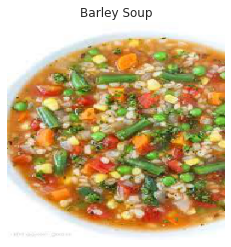

In [83]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = "/content/gdrive/MyDrive/SOUPS NEW/web scrap/Barley Soup/Barley Soup015.jpg"
new_img = image.load_img(image_path, target_size=(256, 256))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()